In [3]:
# impoting libraries
import nltk
import pandas as pd
import numpy as np
import sklearn
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import stem
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import re
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

## EDA

In [4]:
# impoting dataset
df=pd.read_csv('Airline_Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
columns = ['tweet_id', 'airline_sentiment_confidence','negativereason', 'negativereason_confidence',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']
df.drop(columns, axis=1, inplace=True)

In [7]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [8]:
df.shape

(14640, 3)

In [9]:
df.isna().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [13]:
print(Counter(df.airline_sentiment))
print(Counter(df.airline))

Counter({'negative': 9178, 'neutral': 3099, 'positive': 2363})
Counter({'United': 3822, 'US Airways': 2913, 'American': 2759, 'Southwest': 2420, 'Delta': 2222, 'Virgin America': 504})


Text(0.5, 1.0, 'Airline Sentiment Distribution')

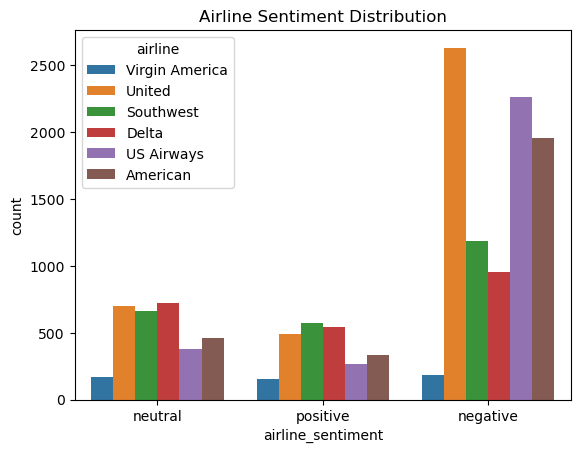

In [11]:
# checking distibution of sentiments 
sn.countplot(x='airline_sentiment', data=df, hue='airline')
plt.title('Airline Sentiment Distribution')

Text(0.5, 1.0, 'Airline Count distributions')

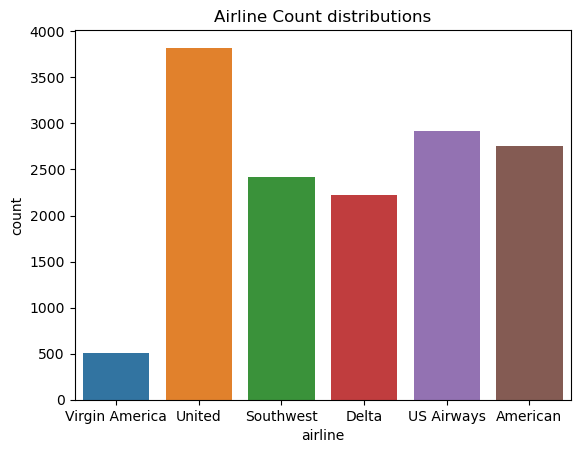

In [12]:
sn.countplot(x='airline', data=df)
plt.title('Airline Count distributions')

In [15]:
# groupin data with airline and sentiments
grouped = df.groupby(['airline', 'airline_sentiment'])
grouped.size()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
dtype: int64

In [16]:
# using cross tab to present in table format
table = pd.crosstab(index=df['airline'], columns=df['airline_sentiment'])
print(table)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


<AxesSubplot: xlabel='airline'>

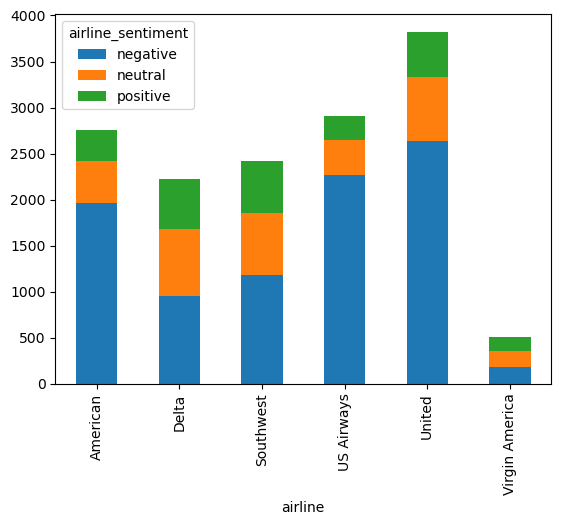

In [20]:
# printing above table with bar graph
table.plot(kind='bar', stacked=True)

In [21]:
#Convert airline feature into number (structured data)
# label encoder or ont hot encoding can be used
# one hot encoding has disadvantages of incresing the dataframe size
# lets use pandas for converting airline to numbers
# nominal and ordinal data, One hot encoding is best suitable for nominal data and label encoding for ordinal data
df['airline'] = pd.factorize(df['airline'])[0]
print(df.airline.unique())

df['airline_sentiment'] = pd.factorize(df['airline_sentiment'])[0]
print(df.airline_sentiment.unique())

# count number of sentiments. It is clear that 0 Nuetral, 1 Positive, 2 Negative
print(Counter(df.airline_sentiment))

print(Counter(df.airline))
# it is clear that O is vergin america, 1 United, 2 Southwest , 3 Delta, 4 Us airways, 5 American

[0 1 2 3 4 5]
[0 1 2]
Counter({2: 9178, 0: 3099, 1: 2363})
Counter({1: 3822, 4: 2913, 5: 2759, 2: 2420, 3: 2222, 0: 504})


In [24]:
for i in range (0,5):
    print([i], df['text'][i])

[0] @VirginAmerica What @dhepburn said.
[1] @VirginAmerica plus you've added commercials to the experience... tacky.
[2] @VirginAmerica I didn't today... Must mean I need to take another trip!
[3] @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
[4] @VirginAmerica and it's a really big bad thing about it


In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...


True

## Cleaning the text

In [28]:
# Creating corpus using Lamatizer
corpus=[]
stemmer=stem.PorterStemmer()
Lematizer=stem.WordNetLemmatizer()

for i in range(0, len(df.text)):
    
    review = re.sub('@VirginAmerica', '', str(df['text'][i]))
    review = re.sub('@united', '', str(review))
    review = re.sub('@SouthwestAir', '', str(review))
    review = re.sub('@JetBlue', '', str(review))
    review = re.sub('@USAirways', '', str(review))
    review = re.sub('@AmericanAir', '', str(review))
    review = re.sub('[^a-zA-Z]', ' ', str(review)) #remove any number and any punctuations in sentence except words.
    
    review = review.lower()
    review = review.split()
    
    review = [Lematizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [29]:
# appending clean text to dataframe
df['Clean_text']=corpus
df

,airline_sentiment,airline,text,Clean_text
0,0,0,@VirginAmerica What @dhepburn said.,dhepburn said
1,1,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,0,0,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,2,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,2,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...,...
14635,1,5,@AmericanAir thank you we got on a different f...,thank got different flight chicago
14636,2,5,@AmericanAir leaving over 20 minutes Late Flig...,leaving minute late flight warning communicati...
14637,0,5,@AmericanAir Please bring American Airlines to...,please bring american airline blackberry
14638,2,5,"@AmericanAir you have my money, you change my ...",money change flight answer phone suggestion ma...


In [30]:
# cterating one hot represenatation and identifying maximum length of the clean text
import time
tic=time.time()
voc_size=20000 # vacabulary size
onehot_repr=[one_hot(words, voc_size)for words in corpus]
len_onehot_repr=[]
len(onehot_repr[0])
for i in range(0,len(onehot_repr)):
    length=len(onehot_repr[i])
    len_onehot_repr.append(length)
print(len(len_onehot_repr))
print(max(len_onehot_repr))
tac=time.time()
print('Time taken by the operation:{}'.format(tac-tic))

14640
22
Time taken by the operation:0.18653440475463867


## Model 

In [31]:
# Building Bidirectional LSTM model
sent_length=25
embedding_vector_features=300
embedded_docs=pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
embedded_docs[0]
nlp_input = Input(shape=(sent_length,),name='nlp_input')
meta_input = Input(shape=(1,),name='meta_input')
emb = Embedding(voc_size, embedding_vector_features, input_length=sent_length)(nlp_input)
nlp_out = Bidirectional(LSTM(128))(emb)
# concatenation of the text data and numeric data
x = concatenate([nlp_out, meta_input])
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=[nlp_input, meta_input], outputs=[x])

In [32]:
# splitting the data
X_final=embedded_docs
S=df.airline
Y=df.airline_sentiment
print(X_final.shape)
print(S.shape)
print(Y.shape)

X_train, X_test, S_train,S_test, y_train, y_test = train_test_split(X_final, S,Y, test_size=.2, random_state=3, stratify=Y)

(14640, 25)
(14640,)
(14640,)


In [33]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [34]:
train_model=model.fit([X_train, S_train], y_train, validation_data=([X_test, S_test], y_test), epochs=100, callbacks=[es])

Epoch 1/100


366/366 [==============================] - 56s 143ms/step - loss: 0.6672 - accuracy: 0.7223 - val_loss: 0.5681 - val_accuracy: 0.7688
Epoch 2/100
366/366 [==============================] - 46s 125ms/step - loss: 0.4145 - accuracy: 0.8382 - val_loss: 0.5634 - val_accuracy: 0.7790
Epoch 3/100
366/366 [==============================] - 50s 138ms/step - loss: 0.2826 - accuracy: 0.8943 - val_loss: 0.6533 - val_accuracy: 0.7719
Epoch 3: early stopping


In [35]:
y_pred=model.predict([X_test, S_test])
y_pred_class=np.argmax(y_pred, axis=1)

92/92 [==============================] - 2s 11ms/step


In [36]:
y_pred

array([[5.2337381e-03, 1.0150799e-04, 9.9466479e-01],
       [6.9669397e-03, 8.5939560e-04, 9.9217367e-01],
       [7.2975069e-02, 6.0513622e-01, 3.2188872e-01],
       ...,
       [1.8418664e-02, 6.1274885e-04, 9.8096859e-01],
       [3.4942452e-04, 3.9014798e-05, 9.9961168e-01],
       [6.0015835e-02, 2.3680653e-02, 9.1630358e-01]], dtype=float32)

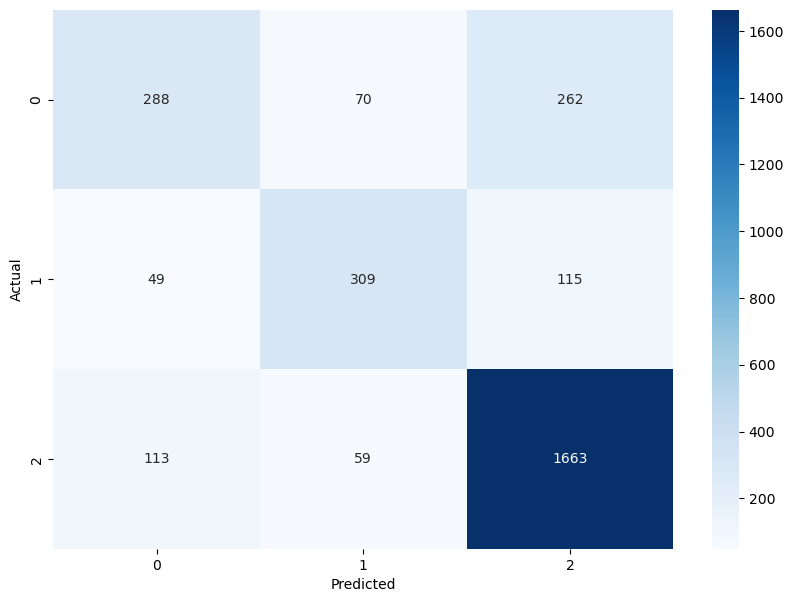

In [38]:
# confusion matrix
cm=confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()